## Graph Neural Networks with BoW Feature Embeddings

In [86]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import wandb

from sklearn.feature_extraction.text import CountVectorizer
import random
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, GCNConv
import ast
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


from typing import Callable, Union
import importlib


import pickle
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.5f}'.format
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 500})'''))

<IPython.core.display.Javascript object>

In [87]:
print(torch.__version__)
if torch.cuda.is_available():
    print("CUDA is available. PyTorch is installed with CUDA support.")
    print(f"CUDA version: {torch.version.cuda}")
else:
    print("CUDA is not available. PyTorch might not be installed with CUDA support.")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

2.4.0
CUDA is available. PyTorch is installed with CUDA support.
CUDA version: 12.1
Using device: cuda


In [88]:
print(os.getcwd())
os.chdir(r'C:\Users\JABEERAK\GNN_mapGitHUb\GCNCodeMap\data') 

C:\Users\JABEERAK\GNN_mapGitHUb\GCNCodeMap\data


# Dataset


In [89]:
df_ant = pd.read_csv('processed\\df_ant.csv')
dep_ant = pd.read_csv('processed\\dep_ant.csv')

df_jab = pd.read_csv('processed\\df_jabref.csv')
dep_jab = pd.read_csv('processed\\dep_jabref.csv')

df_team = pd.read_csv('processed\\df_teammates.csv')
dep_team = pd.read_csv('processed\\dep_teammates.csv')

df_sh = pd.read_csv('processed\\df_sweethome3d.csv')
dep_sh = pd.read_csv('processed\\dep_sweethome3d.csv')

df_argo = pd.read_csv('processed\\df_argouml.csv')
dep_argo = pd.read_csv('processed\\dep_argouml.csv')

df_prom = pd.read_csv('processed\\df_prom.csv')
dep_prom = pd.read_csv('processed\\dep_prom.csv')

df_lucene = pd.read_csv('processed\\df_lucene.csv')
dep_lucene = pd.read_csv('processed\\dep_lucene.csv')

df_common = pd.read_csv('processed\\df_commons-imaging.csv')
dep_common = pd.read_csv('processed\\dep_commons-imaging.csv')

datasets = {
    "Ant": df_ant,
    "A.UML": df_argo,
    "C.Img": df_common,
    "Jabref": df_jab,
    "Lucene": df_lucene,
    "ProM": df_prom,
   "SH-3D": df_sh,
   "T.Mates": df_team,
}

dependencies = {
    "Ant": dep_ant,
    "A.UML": dep_argo,
    "C.Img": dep_common,
    "Jabref": dep_jab,
    'Lucene':dep_lucene,
    "ProM": dep_prom,
    "SH-3D": dep_sh,
    "T.Mates": dep_team,  
}

In [139]:
df_ant.shape

(468, 6)

## 1. Dataset Construction

**Naive Bayes Data**

In [90]:
class DataNB():
    def __init__(self, df,df_dep):
        self.df = df
        self.df_dep =df_dep
        self.x = None
        self.Y = None
        self.n_classes = None
        self.label_encoder = None
        self.process_data()

    def process_data(self):
        """
        Processes the input data to create node features, labels, edge indices, and attributes.
        """
        self._preprocess_dataframes()
        self._generate_embeddings()

    def _preprocess_dataframes(self):
        """
        Preprocesses df and df_dep by mapping Source_File and Target_File from df.
        """
        self.df = self.df[~self.df.Module.isna()]
        self.df_dep = self.df_dep[self.df_dep['Source'].isin(self.df['Entity']) & self.df_dep['Target'].isin(self.df['Entity'])]
        self.df.fillna('', inplace=True)
        valid_ents = set(self.df['Entity'])
        self.df_dep = self.df_dep[self.df_dep['Source'].isin(valid_ents) & self.df_dep['Target'].isin(valid_ents)]
        entity_to_file = self.df.set_index('Entity')['File'].to_dict()
        self.df_dep['Source_File'] = self.df_dep['Source'].map(entity_to_file)
        self.df_dep['Target_File'] = self.df_dep['Target'].map(entity_to_file)

    def _generate_embeddings(self):
        """
        Generates embeddings for CDA and Code columns, ensuring a consistent feature space for all rows.
        """
        self.df['CDA'] = self.df.apply(lambda row: self._generate_cda_text(row), axis=1).str.lower().str.split().str.join(' ')
        corpus = self.df['CDA'].fillna('') + ' ' + self.df['Code'].fillna('')
        count_vectorizer = CountVectorizer()
        self.X = count_vectorizer.fit_transform(corpus).toarray()

        # Encode labels
        self.label_encoder = LabelEncoder()
        self.Y = self.label_encoder.fit_transform(self.df['Module'])
        self.num_classes = len(np.unique(self.Y))

    def _generate_cda_text(self, row):
        """
        Creates CDA text for a given entity by combining dependency text from df_dep
        where the entity appears as Source or Target.
        """
        entity = row['Entity']

        # Find matches where Entity is the Source
        source_matches = self.df_dep[self.df_dep['Source'] == entity]
        source_texts = [
            f"{match['Source_File']} {match['Dependency_Type']} {match['Target_File']}"
            for _, match in source_matches.iterrows()
            if pd.notna(match['Source_File']) and pd.notna(match['Target_File'])
        ]
        # Find matches where Entity is the Target
        target_matches = self.df_dep[self.df_dep['Target'] == entity]
        target_texts = [
            f"{match['Source_File']} {match['Dependency_Type']} {match['Target_File']}"
            for _, match in target_matches.iterrows()
            if pd.notna(match['Source_File']) and pd.notna(match['Target_File'])
        ]

        combined_texts = source_texts + target_texts
        return ' '.join(combined_texts)

    def generate_split(self, q_threshold=0.3, split_ratio=0.05):
        centrality_values = self.df["Closeness_Cenytrality"]
        labels = self.Y
        all_indices = np.arange(len(labels))

        threshold_value = np.quantile(centrality_values, q_threshold)
        high_centrality_indices = all_indices[centrality_values >= threshold_value]
        num_train_samples = max(1, int(split_ratio * len(all_indices)))
        train_indices = np.random.choice(high_centrality_indices, min(len(high_centrality_indices), num_train_samples), replace=False).tolist()
        for cls in np.unique(labels):
            class_indices = all_indices[labels == cls]
            if not any(labels[train_indices] == cls):  
                random_entity = np.random.choice(class_indices)
                train_indices.append(random_entity)

        if len(train_indices) < num_train_samples:
            remaining_candidates = list(set(all_indices) - set(train_indices))
            additional_indices = np.random.choice(remaining_candidates, num_train_samples - len(train_indices), replace=False).tolist()
            train_indices.extend(additional_indices)
        elif len(train_indices) > num_train_samples:
            train_indices = train_indices[:num_train_samples]

        test_indices = np.array(list(set(all_indices) - set(train_indices)))
        np.random.shuffle(train_indices)
        np.random.shuffle(test_indices)

        return train_indices, test_indices

### **Homogeneous Data**

In [107]:
import pandas as pd
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from torch_geometric.data import Data
import torch

class HomogeneousData(Data):
    def __init__(self, df, df_dep):
        super().__init__()
        self.df = df.copy()
        self.df_dep = df_dep.copy()
        self.label_encoder = None
        self.num_classes = None
        self.relations = None
        self.process_data()

    def process_data(self):
        self._preprocess_dataframes()
        self._create_node_features_and_labels()
        self._create_edges()
        self.df = None
        self.df_dep = None

    def _preprocess_dataframes(self):
        self.df = self.df[~self.df.Module.isna()]
        self.df_dep = self.df_dep[self.df_dep['Source'].isin(self.df['Entity']) & self.df_dep['Target'].isin(self.df['Entity'])]

        self.df.fillna('', inplace=True)
        valid_ids = set(self.df['File_ID'])
        self.df_dep = self.df_dep[self.df_dep['Source_ID'].isin(valid_ids) & self.df_dep['Target_ID'].isin(valid_ids)]
        self.df = self.df.reset_index(drop=True)
        file_to_new_id = {old_id: new_id for new_id, old_id in enumerate(self.df['File_ID'])}
        self.df_dep['Source_ID'] = self.df_dep['Source_ID'].map(file_to_new_id)
        self.df_dep['Target_ID'] = self.df_dep['Target_ID'].map(file_to_new_id)
        self.df_dep.dropna(subset=['Source_ID', 'Target_ID'], inplace=True)

    def _create_node_features_and_labels(self):
        self.df['Code'] = self.df['Code'].fillna('')
        code_vectorizer = CountVectorizer(binary=True)
        code_matrix = code_vectorizer.fit_transform(self.df['Code'])
        code_vectors = code_matrix.toarray()

        self.x = torch.tensor(code_vectors, dtype=torch.float)
        self.label_encoder = LabelEncoder()
        self.df['Label'] = self.label_encoder.fit_transform(self.df['Module'])
        self.y = torch.tensor(self.df['Label'].values, dtype=torch.long)
        self.num_classes = len(torch.unique(self.y))

    def _create_edges(self):
        dependency_encoded = pd.get_dummies(self.df_dep['Dependency_Type'], prefix='DepType')
        self.df_dep = pd.concat([self.df_dep, dependency_encoded], axis=1)
        self.edge_index = torch.tensor(
            [self.df_dep['Source_ID'].values, self.df_dep['Target_ID'].values],
            dtype=torch.long
        )
        self.edge_attr = torch.stack([
            torch.tensor(row[dependency_encoded.columns].tolist(), dtype=torch.float)
            for _, row in self.df_dep.iterrows()
        ])
        self.relations = list(self.df_dep.Dependency_Type.unique())

    def generate_split(self, q_threshold=0.3, split_ratio=0.05):
        device = self.y.device
        centrality_values = torch.tensor(self.df["Closeness_Centrality"].values, dtype=torch.float, device=device)
        labels = self.y.to(device)
        all_nodes = torch.arange(len(labels), device=device)
        threshold_value = torch.quantile(centrality_values, q_threshold)
        high_centrality_indices = all_nodes[centrality_values >= threshold_value]

        num_train_samples = max(1, int(split_ratio * len(all_nodes)))
        train_indices = torch.tensor(random.sample(high_centrality_indices.tolist(), min(len(high_centrality_indices), num_train_samples)), dtype=torch.long, device=device)

        for cls in torch.unique(labels):
            class_indices = all_nodes[labels == cls]
            if not any(labels[train_indices] == cls):
                random_entity = class_indices[torch.randint(len(class_indices), (1,))]
                train_indices = torch.cat((train_indices, random_entity))

        if len(train_indices) < num_train_samples:
            remaining_candidates = list(set(all_nodes.tolist()) - set(train_indices.tolist()))
            additional_indices = torch.tensor(random.sample(remaining_candidates, num_train_samples - len(train_indices)), dtype=torch.long, device=device)
            train_indices = torch.cat((train_indices, additional_indices))
        elif len(train_indices) > num_train_samples:
            train_indices = train_indices[:num_train_samples]

        test_indices = torch.tensor(list(set(all_nodes.tolist()) - set(train_indices.tolist())), dtype=torch.long, device=device)
        return train_indices[torch.randperm(len(train_indices))], test_indices[torch.randperm(len(test_indices))]


### **HeteroGenous data**

In [108]:
import pandas as pd
import random
import torch
from torch_geometric.data import HeteroData
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer


class HeterogeneousData(HeteroData):
    def __init__(self, df, df_dep):
        super().__init__()
        self.df = df.copy()
        self.df_dep = df_dep.copy()
        self.label_encoder = None
        self.num_classes = None
        self.relations = None
        self.process_data()

    def process_data(self):
        self._preprocess_dataframes()
        self._create_node_features_and_labels()
        self._create_edges()

    def _preprocess_dataframes(self):
        self.df = self.df[~self.df.Module.isna()]
        self.df_dep = self.df_dep[self.df_dep['Source'].isin(self.df['Entity']) & self.df_dep['Target'].isin(self.df['Entity'])]
        self.df.fillna('', inplace=True)
        valid_ids = set(self.df['File_ID'])
        self.df_dep = self.df_dep[self.df_dep['Source_ID'].isin(valid_ids) & self.df_dep['Target_ID'].isin(valid_ids)]
        self.df = self.df.reset_index(drop=True)

        file_to_new_id = {old_id: new_id for new_id, old_id in enumerate(self.df['File_ID'])}
        self.df_dep['Source_ID'] = self.df_dep['Source_ID'].map(file_to_new_id)
        self.df_dep['Target_ID'] = self.df_dep['Target_ID'].map(file_to_new_id)
        self.df_dep.dropna(subset=['Source_ID', 'Target_ID'], inplace=True)

    def _create_node_features_and_labels(self):
        self.df['Code'] = self.df['Code'].fillna('')
        code_vectorizer = CountVectorizer(binary=True)
        code_matrix = code_vectorizer.fit_transform(self.df['Code'])
        code_vectors = code_matrix.toarray()
        self['entity'].x = torch.tensor(code_vectors, dtype=torch.float)
        self.label_encoder = LabelEncoder()
        self.df['Label'] = self.label_encoder.fit_transform(self.df['Module'])
        self['entity'].y = torch.tensor(self.df['Label'].values, dtype=torch.long)
        self.num_classes = len(torch.unique(self['entity'].y))

    def _create_edges(self):
        self.relations = list(self.df_dep.Dependency_Type.unique())
        edge_dict = defaultdict(list)
        for _, row in self.df_dep.iterrows():
            edge_dict[row['Dependency_Type']].append((row['Source_ID'], row['Target_ID']))
        for dep_type, edges in edge_dict.items():
            source_ids, target_ids = zip(*edges)
            self['entity', dep_type, 'entity'].edge_index = torch.tensor([source_ids, target_ids], dtype=torch.long)


    def generate_split(self, q_threshold=0.3, split_ratio=0.05):
        device = self['entity'].x.device
        centrality_values = torch.tensor(self.df["Closeness_Centrality"].values, dtype=torch.float, device=device)
        labels = self['entity'].y.to(device)
        all_nodes = torch.arange(len(labels), device=device)
        threshold_value = torch.quantile(centrality_values, q_threshold)
        high_centrality_indices = all_nodes[centrality_values >= threshold_value]
        num_train_samples = max(5, int(split_ratio * len(high_centrality_indices)))

        train_indices = torch.tensor(random.sample(high_centrality_indices.tolist(), num_train_samples), dtype=torch.long, device=device)
        test_indices = torch.tensor(list(set(all_nodes.tolist()) - set(train_indices.tolist())), dtype=torch.long, device=device)

        return train_indices[torch.randperm(len(train_indices))], test_indices[torch.randperm(len(test_indices))]



In [ ]:
from models.gnn import GCN, RGCN
from graphs.data import HeterogeneousData, HomogeneousData, DataNB


## **Models**

In [109]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_channels, out_channels, num_layers, dropout=0.1, embed_dim=None):
        """
        Graph Convolutional Network (GCN) model.

        Args:
            input_dim (int): Number of input features per node.
            hidden_channels (int): Number of hidden units per layer.
            out_channels (int): Number of output features (final embedding size).
            num_layers (int): Number of GCN layers.
            dropout (float, optional): Dropout probability applied between layers. Default is 0.1.
            embed_dim (int, optional): If provided, applies a linear transformation to project 
                                       input features to a higher-dimensional space before passing them to GCN layers.
        """
        super(GCN, self).__init__()

        # Feature embedding (optional)
        self.feature_embedder = (
            nn.Sequential(
                nn.Linear(input_dim, embed_dim),
                nn.ReLU(),
                nn.Dropout(0.1)
            ) if embed_dim else None
        )
        
        input_channels = embed_dim if embed_dim else input_dim
        self.convs = nn.ModuleList(
            [GCNConv(input_channels, hidden_channels)] +  
            [GCNConv(hidden_channels, hidden_channels) for _ in range(num_layers - 2)]
            [GCNConv(hidden_channels, out_channels)] 
        )
        
        self.dropout = dropout

    def forward(self, x, edge_index):
        """
        Forward pass of the GCN model.

        Args:
            x (torch.Tensor): Node feature matrix of shape [num_nodes, input_dim].
            edge_index (torch.Tensor): Graph connectivity in COO format of shape [2, num_edges].

        Returns:
            torch.Tensor: Node embeddings of shape [num_nodes, out_channels].
        """
        device = next(self.parameters()).device
        x, edge_index = x.to(device), edge_index.to(device)
        if self.feature_embedder:
            x = self.feature_embedder(x)

        for conv in self.convs[:-1]: 
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training) 
        x = self.convs[-1](x, edge_index)  
        return x


In [110]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, GCNConv


class RGCN(nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers, relations, dropout=0.2, embed_dim=None, input_dim_dict=None):
        """
        Heterogeneous GCN model.
        Args:
            hidden_channels (int): Number of hidden channels.
            out_channels (int): Output feature size.
            num_layers (int): Number of graph convolution layers.
            relations (list of str): List of relation types for heterogeneous graph.
            dropout (float): Dropout probability.
            embed_dim (int, optional): Embedding dimension for node features.
            input_dim_dict (dict, optional): Dictionary mapping node types to input feature dimensions.
        """
        super(RGCN, self).__init__()

        # Feature embedding layers for different node types (if embed_dim is used)
        self.feature_embedder = (
            nn.ModuleDict({
                node_type: nn.Sequential(
                    nn.Linear(input_dim, embed_dim),
                    nn.ReLU(),
                    nn.Dropout(0.1)
                )
                for node_type, input_dim in input_dim_dict.items()
            }) if embed_dim and input_dim_dict else None
        )
        self.convs = nn.ModuleList([
            HeteroConv({
                ('entity', relation, 'entity'): GCNConv(
                    embed_dim if i == 0 else hidden_channels,
                    hidden_channels
                )
                for relation in relations
            })
            for i in range(num_layers)
        ])
        
        self.lin = nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x_dict, edge_index_dict):
        """
        Forward pass of HeteroGCN.
        Args:
            x_dict (dict): Dictionary of node feature tensors for each node type.
            edge_index_dict (dict): Dictionary of edge index tensors for each relation.

        Returns:
            torch.Tensor: Output node embeddings.
        """
        device = next(self.parameters()).device  # Get the model’s device dynamically
        x_dict = {key: x.to(device) for key, x in x_dict.items()}
        edge_index_dict = {key: ei.to(device) for key, ei in edge_index_dict.items()}

        # Apply feature embedding if available
        if self.feature_embedder:
            x_dict = {key: self.feature_embedder[key](x) for key, x in x_dict.items()}

        # Apply graph convolutions
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.relu(x) for key, x in x_dict.items()}
            x_dict = {key: F.dropout(x, p=self.dropout, training=self.training) for key, x in x_dict.items()}

        return self.lin(x_dict['entity'])


# Iterative Learning with varying Degree 

In [131]:
os.chdir(r'C:\Users\JABEERAK\GNN_mapGitHUb\GCNCodeMap') 

from graphs.data import HeterogeneousData, HomogeneousData, DataNB
from utils.train_eval import train, evaluate

In [111]:
from utils.train_eval import train, evaluate

def gnn_learning(data, model, 
                       initial_mapping, 
                       orphans, 
                       loss_fn, 
                       lr, 
                       max_norm, 
                       lambda_t,
                       epochs=50, 
                       verbose=True):
    
    is_heterogeneous = hasattr(data, "x_dict") and hasattr(data, "edge_index_dict")
    device = next(model.parameters()).device
    mapped_entities = initial_mapping.to(device)
    orphans = orphans.to(device)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    predicted_labels = {}
    updated_entities = set()
    iteration = 0
    embeddings = {}

    metrics_history = {
        "f1_micro": [],
        "f1_macro": [],
        "precision_micro": [],
        "precision_macro": [],
        "recall_micro": [],
        "recall_macro": []
    }

    while True:
        for _ in range(epochs):
            # training
            loss = train(model, data, mapped_entities, optimizer, loss_fn, max_norm)

        # evaluating
        high_conf_indices, high_conf_labels, new_orphans, threshold = evaluate(
            model, data, orphans, lambda_t=lambda_t, iteration=iteration
        )

        for idx, label in zip(high_conf_indices.tolist(), high_conf_labels.tolist()):
            predicted_labels[idx] = label

        mapped_entities = torch.cat([mapped_entities, high_conf_indices]).to(device)
        orphans = new_orphans.to(device)

        if len(predicted_labels) > 0:
            mapped_entity_indices = torch.tensor(list(predicted_labels.keys()), device=device)

            if is_heterogeneous:
                out = model(data.x_dict, data.edge_index_dict).to(device)
                probs = torch.softmax(out[mapped_entity_indices], dim=1)
            else:
                out = model(data.x, data.edge_index).to(device)
                probs = torch.softmax(out[mapped_entity_indices], dim=1)
            confidence_scores, new_predictions = torch.max(probs, dim=1)

            embeddings[f'Iteration: {iteration+1}'] = out

            for idx, score, new_label in zip(mapped_entity_indices.tolist(), confidence_scores.tolist(), new_predictions.tolist()):
                if score >= 0.9 and predicted_labels[idx] != new_label:
                    predicted_labels[idx] = new_label
                    updated_entities.add(idx)

        if predicted_labels:
            mapped_entity_indices = list(predicted_labels.keys())
            mapped_predicted_labels = list(predicted_labels.values())
            true_labels = data['entity'].y[mapped_entity_indices].cpu() if is_heterogeneous else data.y[mapped_entity_indices].cpu()

            precision_micro = precision_score(true_labels, mapped_predicted_labels, average='micro')
            precision_macro = precision_score(true_labels, mapped_predicted_labels, average='macro')
            recall_micro = recall_score(true_labels, mapped_predicted_labels, average='micro')
            recall_macro = recall_score(true_labels, mapped_predicted_labels, average='macro')
            f1_micro = f1_score(true_labels, mapped_predicted_labels, average='micro')
            f1_macro = f1_score(true_labels, mapped_predicted_labels, average='macro')

            metrics_history["precision_micro"].append((len(mapped_entities), precision_micro))
            metrics_history["precision_macro"].append((len(mapped_entities), precision_macro))
            metrics_history["recall_micro"].append((len(mapped_entities), recall_micro))
            metrics_history["recall_macro"].append((len(mapped_entities), recall_macro))
            metrics_history["f1_micro"].append((len(mapped_entities), f1_micro))
            metrics_history["f1_macro"].append((len(mapped_entities), f1_macro))
            metrics_history.setdefault("mapped_sizes", []).append((iteration + 1, len(mapped_entities)))
            metrics_history.setdefault("remaining_orphans", []).append((iteration + 1, len(orphans)))

            if verbose:
                print(f"Iteration {iteration + 1} - F1_micro: {f1_micro:.3f}, F1_macro: {f1_macro:.3f}, "
                      f"Confidence Threshold: {threshold:.3f}, Mapped Entities: {len(mapped_entities)}, "
                      f"Updated Entities: {len(updated_entities)}, Remaining Orphans: {len(orphans)}")

        if len(high_conf_indices) == 0 or len(orphans) == 0:
            if verbose:
                print("No new entities mapped or no orphans left. Stopping iterations.")
            break

        iteration += 1

    final_f1_macro = metrics_history["f1_macro"][-1][1] if metrics_history["f1_macro"] else 0.0
    final_f1_micro = metrics_history["f1_micro"][-1][1] if metrics_history["f1_micro"] else 0.0
    final_precision_macro = metrics_history["precision_macro"][-1][1] if metrics_history["precision_macro"] else 0.0
    final_precision_micro = metrics_history["precision_micro"][-1][1] if metrics_history["precision_micro"] else 0.0
    final_recall_macro = metrics_history["recall_macro"][-1][1] if metrics_history["recall_macro"] else 0.0
    final_recall_micro = metrics_history["recall_micro"][-1][1] if metrics_history["recall_micro"] else 0.0

    return embeddings, {
        "initial_set_size": len(initial_mapping),
        "final_mapped_size": len(mapped_entities),
        "final_unmapped_size": len(orphans),
        "final_f1_macro": final_f1_macro,
        "final_f1_micro": final_f1_micro,
        "final_precision_macro": final_precision_macro,
        "final_precision_micro": final_precision_micro,
        "final_recall_macro": final_recall_macro,
        "final_recall_micro": final_recall_micro,
        "mapped_entities_indices": mapped_entities.cpu().numpy(),
        "unmapped_entities_indices": orphans.cpu().numpy(),
        "initial_set_indices": initial_mapping.cpu().numpy()
    }


In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB

def nb_learning(X, Y, initial_mapping_indices, orphans_indices, lambda_t=None, test_mapped_entities=True, verbose=True):
    mapped_entities = initial_mapping_indices
    orphans = orphans_indices
    predicted_labels = {}
    updated_entities = set()
    iteration = 0

    model = MultinomialNB()

    metrics_history = []  # To store metrics for each iteration

    while True:
        # Train the model on currently mapped entities
        X_train = X[mapped_entities]
        Y_train = Y[mapped_entities]
        model.fit(X_train, Y_train)

        # Predict labels and confidence scores for orphans
        X_orphans = X[orphans]
        probs = model.predict_proba(X_orphans)
        confidence_scores = np.max(probs, axis=1)
        predicted_classes = model.classes_[np.argmax(probs, axis=1)]

        # Determine the confidence threshold
        if lambda_t is not None:
            mean_confidence = confidence_scores.mean()
            std_confidence = confidence_scores.std()
            threshold = lambda_t if isinstance(lambda_t, float) else lambda_t(iteration)
            confidence_threshold = mean_confidence + std_confidence * threshold
            confidence_threshold = min(confidence_threshold, 0.99)
        else:
            confidence_threshold = 0.9

        # Identify high-confidence and low-confidence orphans
        high_conf_mask = confidence_scores >= confidence_threshold
        high_conf_indices = orphans[high_conf_mask]
        high_conf_labels = predicted_classes[high_conf_mask]
        low_conf_indices = orphans[~high_conf_mask]

        # Update mappings and labels for high-confidence orphans
        newly_mapped_count = 0
        for idx, label in zip(high_conf_indices, high_conf_labels):
            if idx not in predicted_labels:  # Check if it's a newly mapped entity
                predicted_labels[idx] = label
                newly_mapped_count += 1

        mapped_entities = np.concatenate([mapped_entities, high_conf_indices])
        orphans = low_conf_indices

        # Reevaluate predictions for mapped entities if enabled
        if test_mapped_entities and len(predicted_labels) > 0:
            X_mapped = X[list(predicted_labels.keys())]
            probs_mapped = model.predict_proba(X_mapped)
            confidence_scores_mapped = np.max(probs_mapped, axis=1)
            new_predictions = model.classes_[np.argmax(probs_mapped, axis=1)]

            for idx, score, new_label in zip(predicted_labels.keys(), confidence_scores_mapped, new_predictions):
                if score >= 0.9 and predicted_labels[idx] != new_label:
                    predicted_labels[idx] = new_label
                    updated_entities.add(idx)

        # Verbose iteration details
        if verbose and predicted_labels:
            mapped_entity_indices = list(predicted_labels.keys())
            mapped_predicted_labels = list(predicted_labels.values())
            true_labels = Y[mapped_entity_indices]

            # Calculate metrics
            current_f1_micro = f1_score(true_labels, mapped_predicted_labels, average='micro')
            current_f1_macro = f1_score(true_labels, mapped_predicted_labels, average='macro')
            current_precision_micro = precision_score(true_labels, mapped_predicted_labels, average='micro')
            current_precision_macro = precision_score(true_labels, mapped_predicted_labels, average='macro')
            current_recall_micro = recall_score(true_labels, mapped_predicted_labels, average='micro')
            current_recall_macro = recall_score(true_labels, mapped_predicted_labels, average='macro')

            # Store iteration metrics
            metrics_history.append({
                "iteration": iteration + 1,
                "initial_set_size": len(initial_mapping_indices),  # Include initial set size
                "f1_micro": current_f1_micro,
                "f1_macro": current_f1_macro,
                "precision_micro": current_precision_micro,
                "precision_macro": current_precision_macro,
                "recall_micro": current_recall_micro,
                "recall_macro": current_recall_macro,
                "mapped_ratio": (len(mapped_entities) + len(initial_mapping_indices)) / len(X),
                "remaining_orphans_ratio": len(orphans) / len(X),
            })

            print(f"Iteration {iteration + 1} - F1 Micro: {current_f1_micro:.3f}, "
                  f"F1 Macro: {current_f1_macro:.3f}, "
                  f"Confidence Threshold: {confidence_threshold:.2f}, "
                  f"Mapped Entities: {len(mapped_entities)}, "
                  f"Updated Entities: {len(updated_entities)}, "
                  f"Remaining Orphans: {len(orphans)}")

        # Stopping condition
        if len(high_conf_indices) == 0 or len(orphans) == 0:
            if verbose:
                print("No new entities mapped or no orphans left. Stopping iterations.")
            break

        iteration += 1

    # Final metrics calculation
    final_f1_macro, final_f1_micro = 0.0, 0.0
    final_precision_macro, final_precision_micro = 0.0, 0.0
    final_recall_macro, final_recall_micro = 0.0, 0.0

    if predicted_labels:
        mapped_entity_indices = list(predicted_labels.keys())
        mapped_predicted_labels = list(predicted_labels.values())
        true_labels = Y[mapped_entity_indices]

        final_f1_macro = f1_score(true_labels, mapped_predicted_labels, average='macro')
        final_f1_micro = f1_score(true_labels, mapped_predicted_labels, average='micro')
        final_precision_macro = precision_score(true_labels, mapped_predicted_labels, average='macro')
        final_precision_micro = precision_score(true_labels, mapped_predicted_labels, average='micro')
        final_recall_macro = recall_score(true_labels, mapped_predicted_labels, average='macro')
        final_recall_micro = recall_score(true_labels, mapped_predicted_labels, average='micro')

    # Return final metrics and history
    return {
        "initial_set_size": len(initial_mapping_indices),
        "final_mapped_size": len(mapped_entities),
        "final_unmapped_size": len(orphans),
        "final_f1_macro": final_f1_macro,
        "final_f1_micro": final_f1_micro,
        "final_precision_macro": final_precision_macro,
        "final_precision_micro": final_precision_micro,
        "final_recall_macro": final_recall_macro,
        "final_recall_micro": final_recall_micro,
        "metrics_history": metrics_history,
    }


In [112]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Training with Homogeneous Models

In [114]:
data = {}
for name, df in datasets.items():
    data[name] = HomogeneousData(df,dependencies[name])

data.keys()

dict_keys(['Ant', 'A.UML', 'C.Img', 'Jabref', 'Lucene', 'ProM', 'SH-3D', 'T.Mates'])

In [367]:
# Directories for saving models, logs, and embeddings
weights_dir = 'HomoModel_weights'
logs_dir = 'HomoModel_logs'
embeddings_dir = 'HomoModel_embeddings'
os.makedirs(weights_dir, exist_ok=True)
os.makedirs(HomoModel_logs, exist_ok=True)
os.makedirs(embeddings_dir, exist_ok=True)

num_runs = 500
q_threshold = 0.3
lr = 0.001
hidden_channels = 16
dropout = 0.1
all_metrics = {}
models = {}

splits = {
    "ant": 0.05,
    "argouml":  0.03,
    "jabref":  0.025,
    'lucene':0.03,
    "prom": 0.05,
    "sweetHome": 0.05,
    "teammates":  0.03,
    'common_imaging':0.05
}

for dataset_name, dt in data.items():
    print(f"Running for dataset: {dataset_name}")
    dataset_metrics = []
    split_ratio = splits.get(dataset_name, 0.05)  
    last_successful_embeddings = None 
    last_successful_model_state = None 

    for run in range(num_runs):
        print(f'Run: {run + 1}/{num_runs} for {dataset_name}')
        initial_mapping, orphans = dt.generate_split(q_threshold=q_threshold, split_ratio=split_ratio, centrality='closeness')

        # Initialize the GCN model
        model = GCN(input_dim=dt.x.shape[1],
                    hidden_channels=hidden_channels,
                    out_channels=dt.num_classes,
                    num_layers=1,
                    dropout=dropout,
                    embed_dim=128,
                    device=device
                    )

        model.apply(lambda layer: layer.reset_parameters() if hasattr(layer, 'reset_parameters') else None)

        try:
            # Run the iterative learning process
            embeddings, metrics = iterative_learning(
                dt, model, initial_mapping, orphans,
                loss_fn=torch.nn.CrossEntropyLoss(),
                lr=lr,
                max_norm=5,
                epochs=50,
                lambda_t= lambda t: 0.9 if t < 4 else 1,
                device=device
            )
            metrics["q_threshold"] = q_threshold
            metrics["split_ratio"] = split_ratio
            metrics["lr"] = lr
            metrics["run"] = run + 1

            dataset_metrics.append(metrics)
            last_successful_embeddings = embeddings
            last_successful_model_state = model.state_dict()

        except Exception as e:
            print(f"Run {run + 1} for {dataset_name} failed with error: {e}")

    # Save metrics for the dataset
    metrics_df = pd.DataFrame(dataset_metrics)
    metrics_path = os.path.join(logs_dir, f"{dataset_name}.csv")
    metrics_df.to_csv(metrics_path, index=False)
    print(f"Saved metrics for {dataset_name} at {metrics_path}")

    # Save the model state of the last successful run
    if last_successful_model_state is not None:
        model_path = os.path.join(weights_dir, f"{dataset_name}_model.pt")
        torch.save(last_successful_model_state, model_path)
        print(f"Saved model for {dataset_name} at {model_path}")

    pickle_path = os.path.join(weights_dir, f"{dataset_name}_embedding.pkl")
    with open(pickle_path, 'wb') as f:
        pickle.dump(last_successful_embeddings, f)
    print(f"Saved embeddings as pickle for {dataset_name} at {pickle_path}")

    models[dataset_name] = model
    print(f"Stored model for {dataset_name} in models dictionary")

    # Store metrics for all datasets
    all_metrics[dataset_name] = metrics_df


Running for dataset: common_imaging
Run: 1/500 for common_imaging
Iteration 1 - F1_micro: 0.837, F1_macro: 0.378, Confidence Threshold: 0.879, Mapped Entities: 139, Updated Entities: 0, Remaining Orphans: 190
Iteration 2 - F1_micro: 0.793, F1_macro: 0.505, Confidence Threshold: 0.632, Mapped Entities: 200, Updated Entities: 4, Remaining Orphans: 129
Iteration 3 - F1_micro: 0.885, F1_macro: 0.632, Confidence Threshold: 0.682, Mapped Entities: 234, Updated Entities: 20, Remaining Orphans: 95
Iteration 4 - F1_micro: 0.931, F1_macro: 0.770, Confidence Threshold: 0.666, Mapped Entities: 264, Updated Entities: 29, Remaining Orphans: 65
Iteration 5 - F1_micro: 0.946, F1_macro: 0.805, Confidence Threshold: 0.582, Mapped Entities: 275, Updated Entities: 34, Remaining Orphans: 54
Iteration 6 - F1_micro: 0.955, F1_macro: 0.772, Confidence Threshold: 0.637, Mapped Entities: 283, Updated Entities: 38, Remaining Orphans: 46
Iteration 7 - F1_micro: 0.945, F1_macro: 0.728, Confidence Threshold: 0.564,

## Drawing Graph of Neural Network

## Running Iteratively for all Heterogeenous Datasets 

In [115]:
hetro_data = {}

for name, df in datasets.items():
    hetro_data[name] = HeterogeneousData(df, dependencies[name])
print(hetro_data.keys())

dict_keys(['Ant', 'A.UML', 'C.Img', 'Jabref', 'Lucene', 'ProM', 'SH-3D', 'T.Mates'])


In [116]:
data = hetro_data['Jabref']

In [132]:
import sys
import os

# Add the 'models' folder to the Python path
sys.path.append(os.path.join(os.path.dirname(__file__), '..', 'models'))


NameError: name '__file__' is not defined

In [ ]:
splits = {
    'ant': 0.05,
    'argouml': 0.03,
    'jabref': 0.025,
    'lucene': 0.03,
    'prom': 0.05,
    'teammates': 0.03,
    "SweetHome3D": 0.05,
    'common_imaging':0.05
}


In [120]:
num_runs = 1
q_threshold = 0.3
lr = 0.001
hidden_channels = 16
dropout = 0.2
all_metrics = {}
models = {}

all_embeddings = {}



for dataset_name, dt in hetro_data.items():
    print(f"Running for dataset: {dataset_name}")
    dataset_metrics = []
    split_ratio = splits.get(dataset_name, 0.05)  
    last_successful_embeddings = None 
    last_successful_model_state = None 
    for run in range(num_runs):
        print(f'Run: {run + 1}/{num_runs} for {dataset_name}')
        initial_mapping, orphans = dt.generate_split(q_threshold=q_threshold, split_ratio=split_ratio)

        # Initialize the GCN model
        model = RGCN(hidden_channels=hidden_channels,
                    out_channels=dt.num_classes,
                    num_layers=1,
                    dropout=dropout,
                    embed_dim=128,
                    input_dim_dict={'entity': dt['entity'].x.shape[1]},
                    relations = dt.relations)

        model.apply(lambda layer: layer.reset_parameters() if hasattr(layer, 'reset_parameters') else None)

        try:
            # Run the iterative learning process
            embeddings, metrics = gnn_learning(
                dt, model, initial_mapping, orphans,
                loss_fn=torch.nn.CrossEntropyLoss(),
                lr=lr,
                max_norm=5,
                epochs=50,
                lambda_t=0.8,
                device=device
            )
            metrics["run"] = run + 1

            dataset_metrics.append(metrics)
            last_successful_embeddings = embeddings
            last_successful_model_state = model.state_dict()

            # Transfer embeddings to CPU before storing
            all_embeddings[dataset_name] = {
                iteration: embedding.detach().cpu()
                for iteration, embedding in embeddings.items()
            }

        except Exception as e:
            print(f"Run {run + 1} for {dataset_name} failed with error: {e}")

Running for dataset: Ant
Run: 1/1 for Ant
Iteration 1 - F1_micro: 0.509, F1_macro: 0.146, Confidence Threshold: 0.766, Mapped Entities: 239, Updated Entities: 0, Remaining Orphans: 229
Iteration 2 - F1_micro: 0.832, F1_macro: 0.547, Confidence Threshold: 0.646, Mapped Entities: 315, Updated Entities: 90, Remaining Orphans: 153
Iteration 3 - F1_micro: 0.936, F1_macro: 0.906, Confidence Threshold: 0.608, Mapped Entities: 366, Updated Entities: 133, Remaining Orphans: 102
Iteration 4 - F1_micro: 0.958, F1_macro: 0.942, Confidence Threshold: 0.533, Mapped Entities: 402, Updated Entities: 153, Remaining Orphans: 66
Iteration 5 - F1_micro: 0.977, F1_macro: 0.982, Confidence Threshold: 0.517, Mapped Entities: 421, Updated Entities: 165, Remaining Orphans: 47
Iteration 6 - F1_micro: 0.988, F1_macro: 0.978, Confidence Threshold: 0.471, Mapped Entities: 432, Updated Entities: 173, Remaining Orphans: 36
Iteration 7 - F1_micro: 0.976, F1_macro: 0.981, Confidence Threshold: 0.453, Mapped Entities: 

## **Training with Naive Bayes Data**

In [121]:
nb_dataset = {}
for name, df, in datasets.items():
    nb_dataset[name] = DataNB(df,dependencies[name])

## Tsne Representation of Feature Embeddings

Ant: Embeddings shape - torch.Size([468, 14])
A.UML: Embeddings shape - torch.Size([767, 15])
C.Img: Embeddings shape - torch.Size([329, 21])
Jabref: Embeddings shape - torch.Size([1015, 6])
Lucene: Embeddings shape - torch.Size([510, 7])
ProM: Embeddings shape - torch.Size([261, 4])
SH-3D: Embeddings shape - torch.Size([167, 9])
T.Mates: Embeddings shape - torch.Size([779, 15])


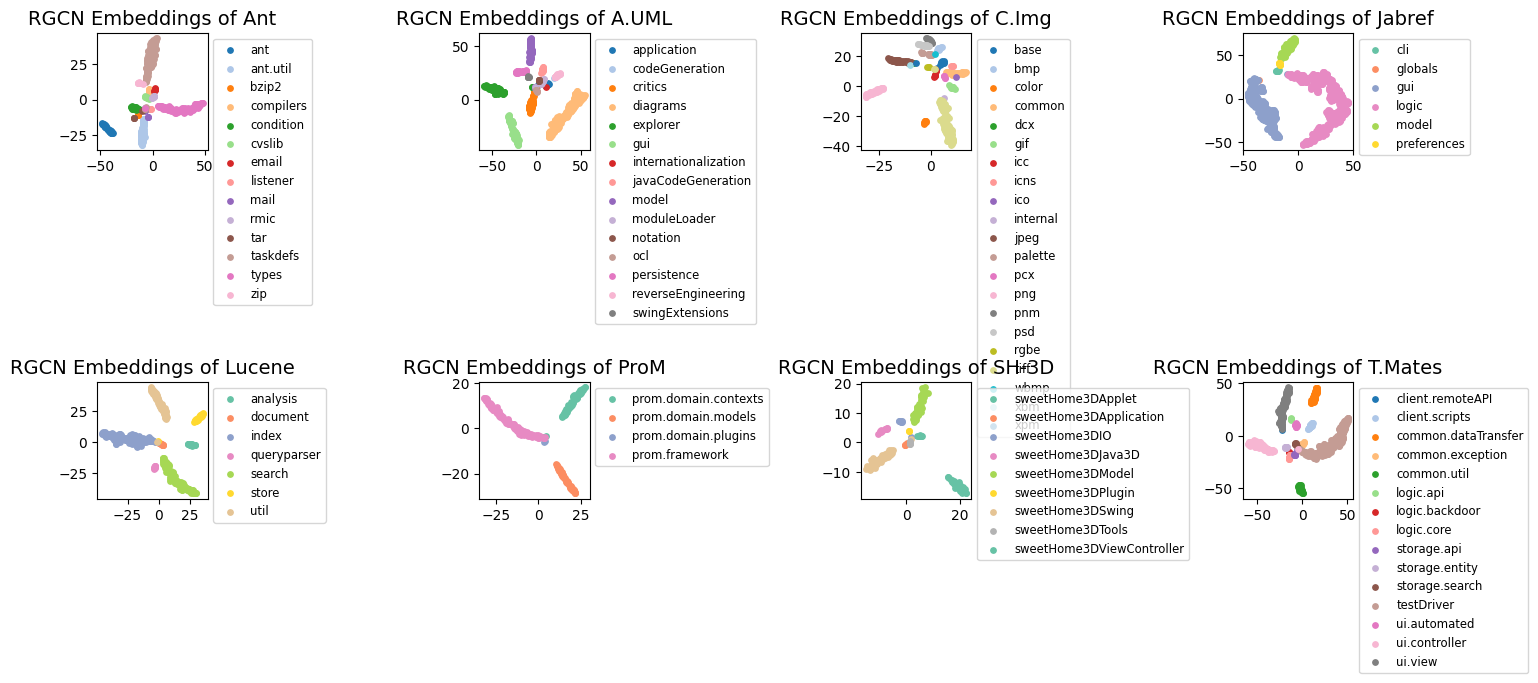

Ant: Embeddings shape - torch.Size([468, 14])
A.UML: Embeddings shape - torch.Size([767, 15])
C.Img: Embeddings shape - torch.Size([329, 21])
Jabref: Embeddings shape - torch.Size([1015, 6])
Lucene: Embeddings shape - torch.Size([510, 7])
ProM: Embeddings shape - torch.Size([261, 4])
SH-3D: Embeddings shape - torch.Size([167, 9])
T.Mates: Embeddings shape - torch.Size([779, 15])


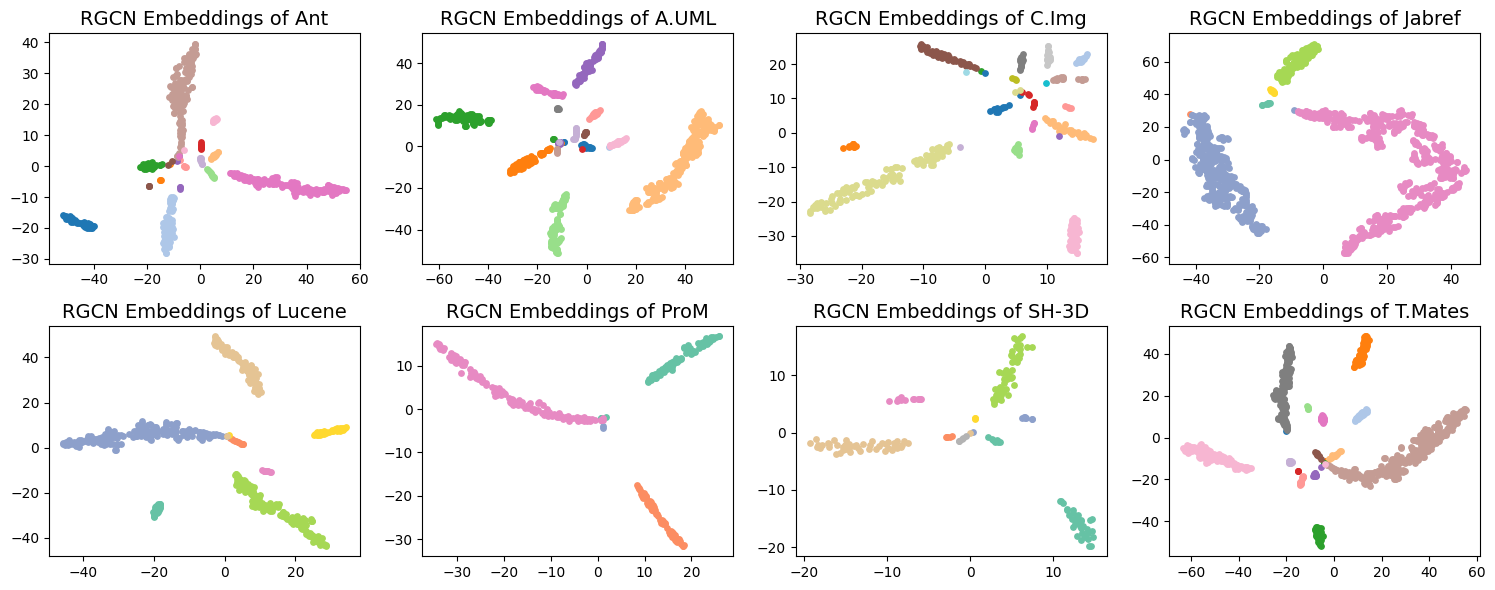

In [19]:
import os
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def create_combined_plot(models, dataset, with_legend=True, output_dir='tsne_plots', output_name="tsne.png"):
    plt.figure(figsize=(15, 6)) 
    num_datasets = len(models)
    rows = 2
    cols = min(num_datasets, 4)  

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check device

    for idx, (name, model) in enumerate(models.items(), start=1):
        d = dataset[name]
        model.eval()
        model.to(device)  # Ensure the model is on the correct device

        if hasattr(d, 'x') and hasattr(d, 'edge_index'): 
            node_features = d.x.to(device)
            edge_index = d.edge_index.to(device)
            labels = d.y.to(device)
        else:
            node_features = {k: v.to(device) for k, v in d.x_dict.items()}
            edge_index = {k: v.to(device) for k, v in d.edge_index_dict.items()}
            labels = d['entity'].y.to(device)
        
        with torch.no_grad():
            if hasattr(d, 'x') and hasattr(d, 'edge_index'): 
                embeddings = model(node_features, edge_index).to(device)
            else:  
                embeddings = model(node_features, edge_index).to(device)

        # Perform t-SNE
        print(f"{name}: Embeddings shape - {embeddings.shape}")
        tsne = TSNE(
            n_components=2,
            perplexity=20,
            learning_rate=200,
            n_iter=1000,
            random_state=42
        )
        embeddings_2d = tsne.fit_transform(embeddings.cpu().numpy())

        # Adjust color palette based on the number of classes
        unique_labels = torch.unique(labels)
        num_classes = len(unique_labels)
        class_names = d.label_encoder.classes_
        if num_classes <= 10:
            palette = sns.color_palette("Set2", num_classes)
        else:
            palette = sns.color_palette("tab20", num_classes)

        # Add subplot
        plt.subplot(rows, cols, idx)
        for cls, color in zip(unique_labels, palette):
            cls_mask = (labels == cls)
            plt.scatter(
                embeddings_2d[cls_mask.cpu().numpy(), 0],
                embeddings_2d[cls_mask.cpu().numpy(), 1],
                label=f"{class_names[cls.item()]}",
                color=color,
                s=15
            )

        plt.title(f"RGCN Embeddings of {name}", fontsize=14)
        plt.xlabel("")
        plt.ylabel("")
        if with_legend:
            plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize="small")

    # Save combined plot
    plt.tight_layout()
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches='tight', format='pdf')
    plt.show()


# Call the function
output_dir = 'tsne_plots'
create_combined_plot(models=models, dataset=hetro_data, with_legend=True, output_dir=output_dir, output_name="tsne_HGCN_legend.pdf")
create_combined_plot(models=models, dataset=hetro_data, with_legend=False, output_dir=output_dir, output_name="tsne_HGCN.pdf")




In [165]:
names = data.keys()

dict_keys(['Ant', 'A.UML', 'C.Img', 'Jabref', 'Lucene', 'ProM', 'SH-3D', 'T.Mates'])

## Node Embeddings in All Iteration

In [20]:
hetro_data.keys()

dict_keys(['Ant', 'A.UML', 'C.Img', 'Jabref', 'Lucene', 'ProM', 'SH-3D', 'T.Mates'])

In [21]:
dt = hetro_data['C.Img']

In [32]:
num_runs = 1
q_threshold = 0.3
lr = 0.001
hidden_channels = 16
dropout = 0.2

# Dictionary to store embeddings
embeddings = {}

initial_mapping, orphans = dt.generate_split(q_threshold=q_threshold, split_ratio=0.05, centrality='closeness')

# Initialize the GCN model
model = HeteroGCN(hidden_channels=hidden_channels,
                    out_channels=dt.num_classes,
                    num_layers=1,
                    dropout=0.2,
                    embed_dim=128,
                    input_dim_dict={'entity': dt['entity'].x.shape[1]},
                    device=device)

model.apply(lambda layer: layer.reset_parameters() if hasattr(layer, 'reset_parameters') else None)


# Run the iterative learning process
emb, _ = iterative_learning(
    dt, model, initial_mapping, orphans,
    loss_fn=torch.nn.CrossEntropyLoss(),
    lr=lr,
    max_norm=5,
    epochs=50,
    lambda_t=0.8,
    device=device
)

# Flatten and store embeddings in the dictionary
for iteration, embedding in emb.items():
    embeddings[iteration] = embedding.detach().cpu()


Iteration 1 - F1_micro: 0.750, F1_macro: 0.259, Confidence Threshold: 0.762, Mapped Entities: 152, Updated Entities: 0, Remaining Orphans: 177
Iteration 2 - F1_micro: 0.917, F1_macro: 0.694, Confidence Threshold: 0.552, Mapped Entities: 204, Updated Entities: 28, Remaining Orphans: 125
Iteration 3 - F1_micro: 0.987, F1_macro: 0.935, Confidence Threshold: 0.549, Mapped Entities: 238, Updated Entities: 44, Remaining Orphans: 91
Iteration 4 - F1_micro: 0.953, F1_macro: 0.838, Confidence Threshold: 0.470, Mapped Entities: 269, Updated Entities: 47, Remaining Orphans: 60
Iteration 5 - F1_micro: 0.985, F1_macro: 0.972, Confidence Threshold: 0.453, Mapped Entities: 281, Updated Entities: 57, Remaining Orphans: 48
Iteration 6 - F1_micro: 1.000, F1_macro: 1.000, Confidence Threshold: 0.489, Mapped Entities: 292, Updated Entities: 61, Remaining Orphans: 37
Iteration 7 - F1_micro: 0.986, F1_macro: 0.981, Confidence Threshold: 0.394, Mapped Entities: 303, Updated Entities: 61, Remaining Orphans: 2

In [36]:
def plot_iteration_embeddings(embeddings, labels, save_dir='tsne_plots', max_columns=5):
    """
    Plots t-SNE visualization of embeddings for each iteration in the correct order and saves the combined plot.

    Args:
        embeddings (dict): Dictionary of embeddings with string keys like 'Iteration: 1'.
        labels (tensor): Tensor of class labels corresponding to the embeddings.
        save_dir (str): Directory to save the resulting plot.
        max_columns (int): Maximum number of columns for subplot layout.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Sort keys numerically based on the iteration number
    sorted_iterations = sorted(embeddings.keys(), key=lambda x: int(x.split(': ')[1]))

    # Determine layout for subplots
    num_iterations = len(sorted_iterations)
    fig_rows = (num_iterations + max_columns - 1) // max_columns
    fig_cols = min(num_iterations, max_columns)
    fig_size = (15, 7)

    # Determine unique labels and color palette
    unique_labels = torch.unique(labels)
    num_classes = len(unique_labels)
    palette = sns.color_palette("tab20", num_classes) if num_classes > 10 else sns.color_palette("Set2", num_classes)

    # Prepare figure
    fig, axes = plt.subplots(fig_rows, fig_cols, figsize=fig_size, squeeze=False)
    axes = axes.flatten()

    for idx, iteration in enumerate(sorted_iterations):
        embedding_tensor = embeddings[iteration]

        # Use TSNE for dimensionality reduction
        tsne = TSNE(n_components=2, perplexity=20, learning_rate=200, n_iter=1000, random_state=42)
        embeddings_2d = tsne.fit_transform(embedding_tensor.detach().cpu().numpy())

        # Plot each class in the same order as labels
        ax = axes[idx]
        for cls, color in zip(unique_labels, palette):
            cls_mask = (labels == cls)  # Mask for nodes of the current class
            ax.scatter(
                embeddings_2d[cls_mask.cpu().numpy(), 0],
                embeddings_2d[cls_mask.cpu().numpy(), 1],
                label=f"Class {cls.item()}",
                color=color,
                s=15
            )

        ax.set_title(f"{iteration}", fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])

    # Turn off unused axes
    for ax in axes[num_iterations:]:
        ax.axis('off')

    plot_path = os.path.join(save_dir, "common_img_embeddings.pdf")
    plt.suptitle('RGCN Iterative Node Embeddings of C.Img', fontsize=18)
    plt.tight_layout()
    plt.savefig(plot_path, format='pdf', bbox_inches='tight')
    plt.show()
    print(f"Combined t-SNE plot saved at: {plot_path}")


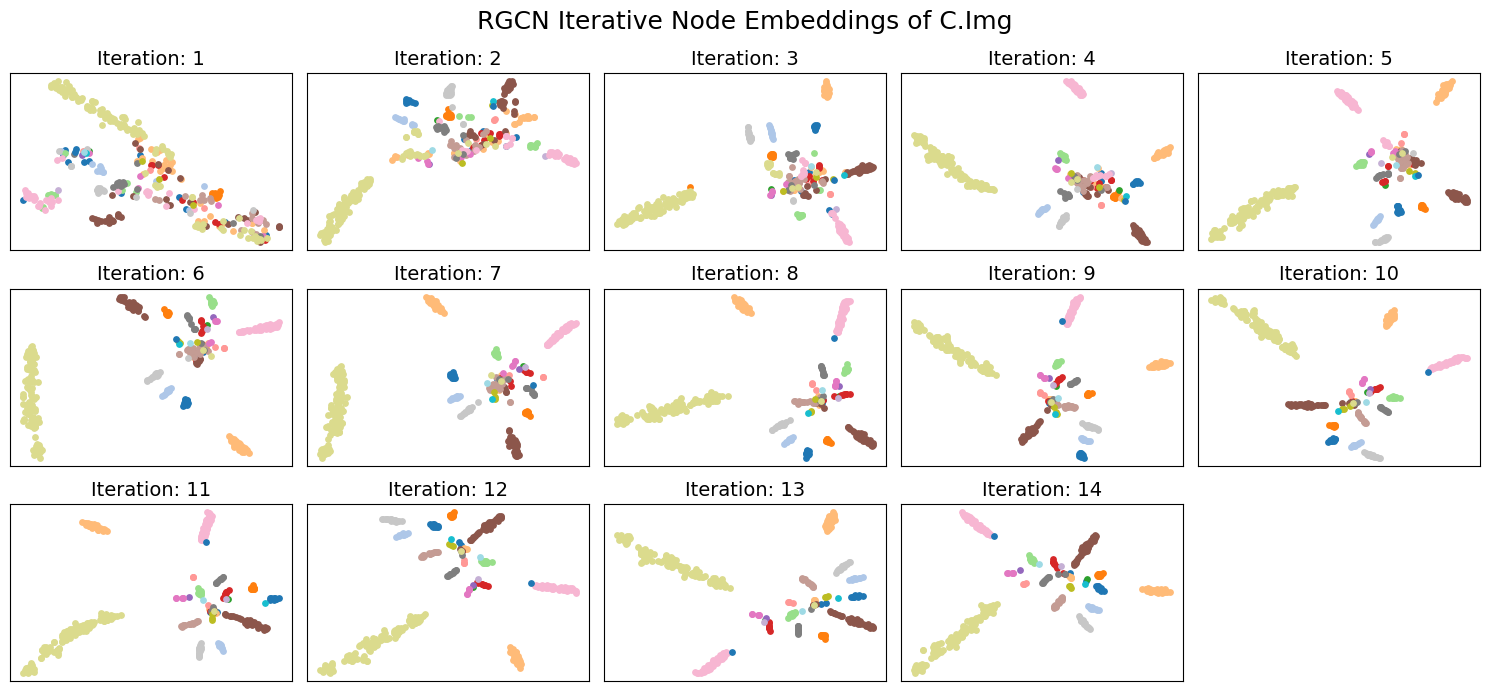

Combined t-SNE plot saved at: tsne_plots\common_img_embeddings.pdf


In [37]:
plot_iteration_embeddings(embeddings, labels=dt['entity'].y, save_dir='tsne_plots', max_columns=5)